In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fit_library as ft
import os
import matplotlib.gridspec as gridspec
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def read_hdf(hdf5_name = "my_data.hdf"):
    data = pd.read_hdf(hdf5_name,key='data')
    env = pd.read_hdf(hdf5_name,key='env')
    return data,env

def filter_data(Q1,Q2,time_diff,x1Q1,x2Q1,x1Q2,x2Q2):
    # Filter Energy Ranges in Q1 and Q2
    indexer=np.where(
        np.logical_and(
            np.logical_and(
                np.greater_equal(Q1,x1Q1),
                np.less_equal(Q1,x2Q1)),
            np.logical_and(
                np.greater_equal(Q2,x1Q2),
                np.less_equal(Q2,x2Q2)
                          )
                      ))
    Q1_sel = Q1[indexer]
    Q2_sel = Q2[indexer]
    time_diff_sel = time_diff[indexer]
    
    return Q1_sel,Q2_sel,time_diff_sel


        

<IPython.core.display.Javascript object>


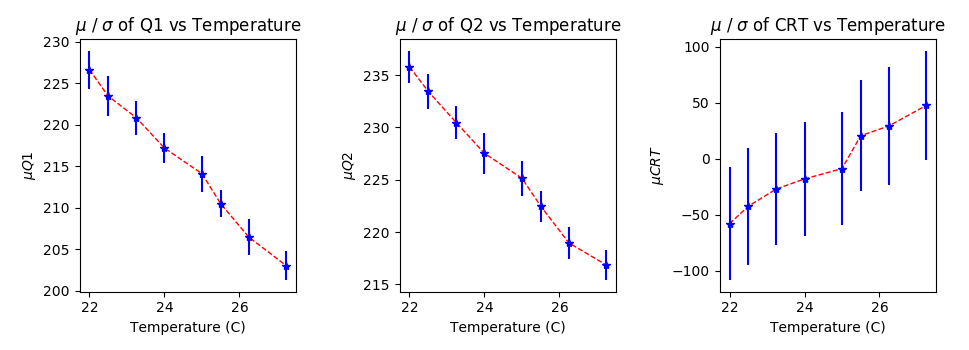

In [3]:
n_files_a=1; n_files_b=9
#dir_name = "/home/viherbos/DAQ_DATA/MU_vs_Time/"
dir_name = "/home/viherbos/DAQ_DATA/"
filename = "c_temp_sweep"

coeffTDa = np.zeros((n_files_b-n_files_a,3))
coeffQ1a = np.zeros((n_files_b-n_files_a,3))
coeffQ2a = np.zeros((n_files_b-n_files_a,3))
tempa    = np.zeros((n_files_b-n_files_a,1))

Q1_fit = ft.gauss_fit()
Q2_fit = ft.gauss_fit()
td_fit = ft.gauss_fit()

for i in range(n_files_a,n_files_b):
    hdf_filename = filename +"_"+str(i)+".hdf"
    DATA,TEMP = read_hdf(dir_name + hdf_filename)

    Q1  = np.array(DATA.loc[:,'Q1'])
    Q2  = np.array(DATA.loc[:,'Q2'])
    ts1 = np.array(DATA.loc[:,'timestamp1'])
    ts2 = np.array(DATA.loc[:,'timestamp2'])
    time_diff = ts1-ts2
    temp = np.mean(np.array(TEMP.loc[:,'temp']))

    Q1_sel,Q2_sel,time_diff_sel = filter_data(Q1,Q2,time_diff,200,300,200,300)
    
    # Call class instance for fitting operation
    for j in range(0,2):
        Q1_fit(Q1_sel,'sqrt')
        Q2_fit(Q2_sel,'sqrt')
        td_fit(time_diff_sel,'sqrt')

        x1Q1 = Q1_fit.coeff[1]-1.175*np.absolute(Q1_fit.coeff[2])
        x2Q1 = Q1_fit.coeff[1]+1.175*np.absolute(Q1_fit.coeff[2])
        x1Q2 = Q2_fit.coeff[1]-1.175*np.absolute(Q2_fit.coeff[2])
        x2Q2 = Q2_fit.coeff[1]+1.175*np.absolute(Q2_fit.coeff[2]) 
        Q1_sel,Q2_sel,time_diff_sel = filter_data(Q1,Q2,time_diff,x1Q1,x2Q1,x1Q2,x2Q2)
    
    coeffTDa[i-n_files_a,:] = td_fit.coeff
    coeffQ1a[i-n_files_a,:] = Q1_fit.coeff
    coeffQ2a[i-n_files_a,:] = Q2_fit.coeff
    tempa[i-n_files_a,:]    = temp

#TD_mu_dev = ft.gauss_fit2();Q1_mu_dev = ft.gauss_fit();Q2_mu_dev = ft.gauss_fit()
#TD_mu_dev(coeffTDa[:,1],[-100,10,-80,10],'sqrt');Q1_mu_dev(coeffQ1a[:,1],'sqrt');Q2_mu_dev(coeffQ2a[:,1],'sqrt')
    
    
fig=plt.figure(figsize=(9,3.5)) 
fig.canvas.set_window_title("") 
gs = gridspec.GridSpec( nrows=4, ncols=3, width_ratios=[2, 2, 2]) 
ax0 = fig.add_subplot(gs[:, 0]) 
ax1 = fig.add_subplot(gs[:, 1]) 
ax2 = fig.add_subplot(gs[:, 2])
ax2.cla(); ax0.cla(); ax1.cla() 
ax0.set_xlabel("Temperature (C)")
ax0.set_ylabel("$\mu Q1$")
ax0.set_title("$\mu$ / $\sigma$ of Q1 vs Temperature")
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("$\mu Q2$")
ax1.set_title("$\mu$ / $\sigma$ of Q2 vs Temperature")
ax2.set_xlabel("Temperature (C)")
ax2.set_ylabel("$\mu CRT$")
ax2.set_title("$\mu$ / $\sigma$ of CRT vs Temperature")

ax0.plot(tempa,coeffQ1a[:,1],'r--', linewidth=1)
ax0.errorbar(tempa, coeffQ1a[:,1], fmt='b*', yerr=coeffQ1a[:,2]/2)
ax1.plot(tempa,coeffQ2a[:,1],'r--', linewidth=1)
ax1.errorbar(tempa, coeffQ2a[:,1], fmt='b*', yerr=coeffQ2a[:,2]/2)
ax2.plot(tempa,coeffTDa[:,1],'r--', linewidth=1)
ax2.errorbar(tempa, coeffTDa[:,1], fmt='b*', yerr=coeffTDa[:,2]/2)

plt.tight_layout() 
plt.draw()